In [3]:
from random import randint, sample, random, seed
from itertools import chain
from scipy import sparse
from scipy.special import expit
import numpy as np
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from numpy.random import choice, normal
from numpy import array
from math import floor, ceil

%matplotlib inline

print = PrettyPrinter(indent=4).pprint

In [4]:
_INITIAL_UNITS = 1

_INITIAL_MIN_NODES = 8

_INITIAL_MAX_NODES = 14

_INITIAL_LAYERS_MIN = 3

_INITIAL_LAYERS_MAX = 6

_INITIAL_MU_RANGE = 0.5

_INITIAL_SIGMA = 0.3

_INITIAL_OUTDEGREE_MIN = 1

_INITIAL_OUTDEGREE_MAX = 4

_INITIAL_PROJECTIONS_PER_LAYER = 2

_N_INPUT_UNITS = 14

_N_OUTPUT_UNITS = 5


def _rand_range(rng):
    return random() * 2 * rng - rng



def _create_initial_structure():
    """Create the inital randomized structure for the agent.

    For the structure, see the ANNStructuredAgent configuration below.

    """
    #seed(11)
    # Create units (populations or columns) and layers with their nodes count.
    structure = [
        [(randint(_INITIAL_MIN_NODES, _INITIAL_MAX_NODES), {})
            for _ in range(randint(_INITIAL_LAYERS_MIN, _INITIAL_LAYERS_MAX))]
        for _ in range(_INITIAL_UNITS)
    ]
    
    structure[0][0] = (_N_INPUT_UNITS, {})    
    structure[-1][-1] = (_N_OUTPUT_UNITS, {})

    # For each layer in each unit: add the configuration (connections).

    for j, unit in enumerate(structure):
        for i, (num_nodes, conns) in enumerate(unit):
            # Connect this layer to other layers in the same unit.
           
            others = sample([n for n in range(len(unit)) if n != 0], _INITIAL_PROJECTIONS_PER_LAYER)
            
            for o in others:
                conns[o] = (
                    _rand_range(_INITIAL_MU_RANGE), _INITIAL_SIGMA,
                    randint(_INITIAL_OUTDEGREE_MIN, _INITIAL_OUTDEGREE_MAX))

            # Connect the last layer of the current unit to other units.

            if i == len(unit) - 1 and j < len(structure) - 1:
                others = [n for n in range(len(structure)) if n != j]
                conns_to_layer = {
                    n: (abs(_rand_range(_INITIAL_MU_RANGE)), _INITIAL_SIGMA,
                        randint(
                            _INITIAL_OUTDEGREE_MIN, _INITIAL_OUTDEGREE_MAX))
                    for n in others}
                conns[None] = conns_to_layer

    return structure

structure = _create_initial_structure()



def _node_index(nodes, to_layer):
    #print(to_layer)
    start = sum(nodes[:to_layer])
    stop = start + nodes[to_layer]
    return list(range(start,stop))

def _projections(out_degree=4.4, n_projecting_nodes=10):
    low = int(floor(out_degree))
    high = int(ceil(out_degree))
    pl = high - out_degree
    ph = 1 - pl
    return array(choice([low, high], n_projecting_nodes, p=[pl, ph]), dtype=int)


def create_matrix(structure):
    
    nodes_per_layer = list(chain.from_iterable([[i[0] for i in j] for j in structure]))
    n_nodes = sum(nodes_per_layer)
    print(n_nodes)
    layers_per_unit = [len(unit) for unit in structure]

    accum_layers_per_unit = [sum(layers_per_unit[0:i]) for i in range(len(layers_per_unit))]

    wheight_matrix = sparse.lil_matrix((n_nodes, n_nodes))
    wheight_matrix_normal = np.zeros((n_nodes, n_nodes))

    for j, unit in enumerate(structure):
        for i, (num_nodes, conns) in enumerate(unit):
            from_nodes = _node_index(nodes_per_layer, i + accum_layers_per_unit[j])

            # from_nodes är en lista med alla "från-noder" i aktuellt i
            others = conns.keys()

            for o in others:
                if o:
                    to_layer = o + accum_layers_per_unit[j]
                    #print("from " + str(from_nodes) + " to layer: " + str(to_layer))
                    for from_node, n_projections in zip(from_nodes,
                                                        _projections(conns[o][2], num_nodes)):
                        for to_node in choice(_node_index(nodes_per_layer, to_layer),
                                              n_projections):
                            wheight = normal(conns[o][0], conns[o][1], 1)[0]
                            wheight_matrix[to_node, from_node] = wheight
                            wheight_matrix_normal[to_node][from_node] = wheight
                else:
                    # this happens if other (o) is none
                    conns_to_layer = conns[o]
                    for to_unit in conns_to_layer.keys():
                        if to_unit:
                            to_layer = accum_layers_per_unit[to_unit]
                            for from_node, n_projections in zip(from_nodes,
                                                                _projections(conns_to_layer[to_unit][2], 
                                                                             num_nodes)):

                                for to_node in choice(_node_index(nodes_per_layer, to_layer), 
                                                      n_projections):

                                    wheight = normal(conns_to_layer[to_unit][0], conns_to_layer[to_unit][1], 1)[0]
#                                     wheight = normal(j+1, 0.1, 1)[0]
                                    wheight_matrix[to_node, from_node] = wheight
                                    wheight_matrix_normal[to_node][from_node] = wheight
                                
    return wheight_matrix, wheight_matrix_normal, n_nodes

wheight_matrix, wheight_matrix_normal, n_nodes = create_matrix(structure)

55


55
array([1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1])


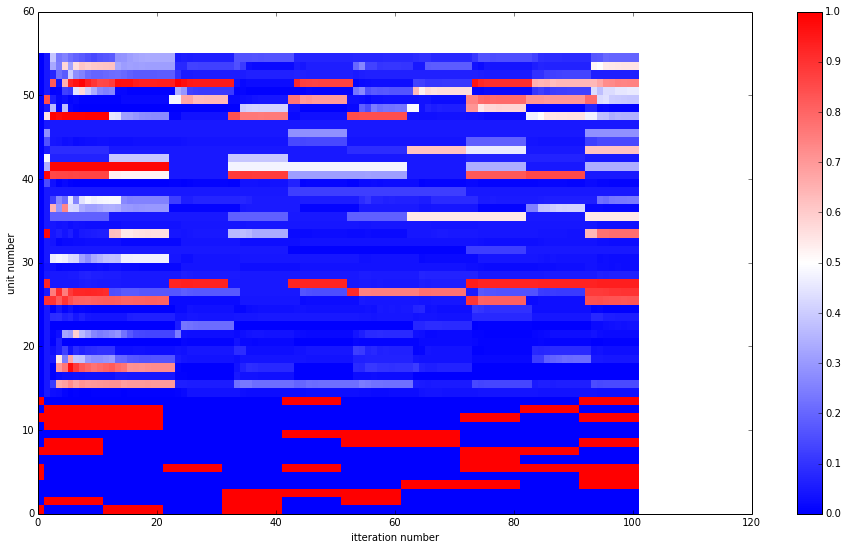

In [5]:
dim = wheight_matrix_normal.shape

work_vec = np.zeros(dim[0])
print(len(work_vec))

frac = 7
shift = 3

outResult = work_vec
input_vec = np.random.choice([0, 1], _N_INPUT_UNITS, p=(0.7, 0.3))
print(input_vec)
work_vec[0:_N_INPUT_UNITS] = input_vec
for i in range(100):
    if i%10 == 0: 
        input_vec = np.random.choice([0, 1], _N_INPUT_UNITS, p=(0.7, 0.3))
    work_vec = (expit(wheight_matrix.dot(work_vec)*frac-shift))
    work_vec[0:_N_INPUT_UNITS] = input_vec
    outResult = np.vstack((outResult,work_vec))

plt.figure(figsize=(16,9))
plt.pcolor(np.transpose(outResult), cmap='bwr')
plt.ylabel('unit number')
plt.xlabel('itteration number')
bar = plt.colorbar()
# plt.savefig('nodes_evolution.png')

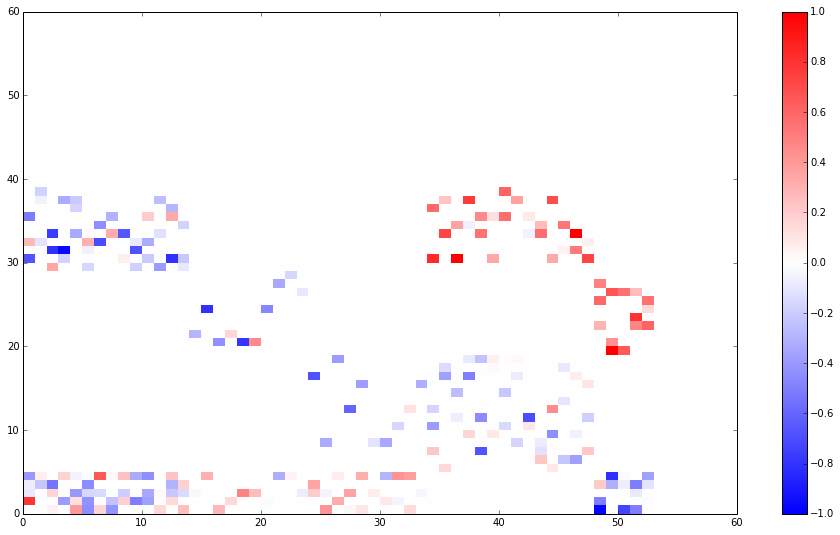

In [4]:
plt.figure(figsize=(16,9))
heat = plt.pcolor(np.flipud(wheight_matrix_normal), cmap='bwr', vmax=1, vmin=-1)
bar = plt.colorbar()
# plt.savefig('wheight_matrix.pdf', type='pdf')

In [67]:
def foo(result, i):
    i += 1
    print((i, result))
    if i == 10: 
        return result
    else: 
        foo(expit(result), i)

foo(0, 0)
1-1/np.e

(1, 0)
(2, 0.5)
(3, 0.62245933120185459)
(4, 0.65077767821470045)
(5, 0.65718568927725118)
(6, 0.65862790952095107)
(7, 0.65895210003927285)
(8, 0.65902495299094022)
(9, 0.65904132366557999)
(10, 0.65904500224248297)


0.6321205588285577

In [110]:
np.random.choice(2,_N_INPUT_UNITS)


array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1])

In [127]:
a= 4
a%4

0

In [99]:
a = np.array([1,2,3,4])
np.vstack((a,a))

a = np.zeros(dim[0])
np.vstack((a,a))



array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,

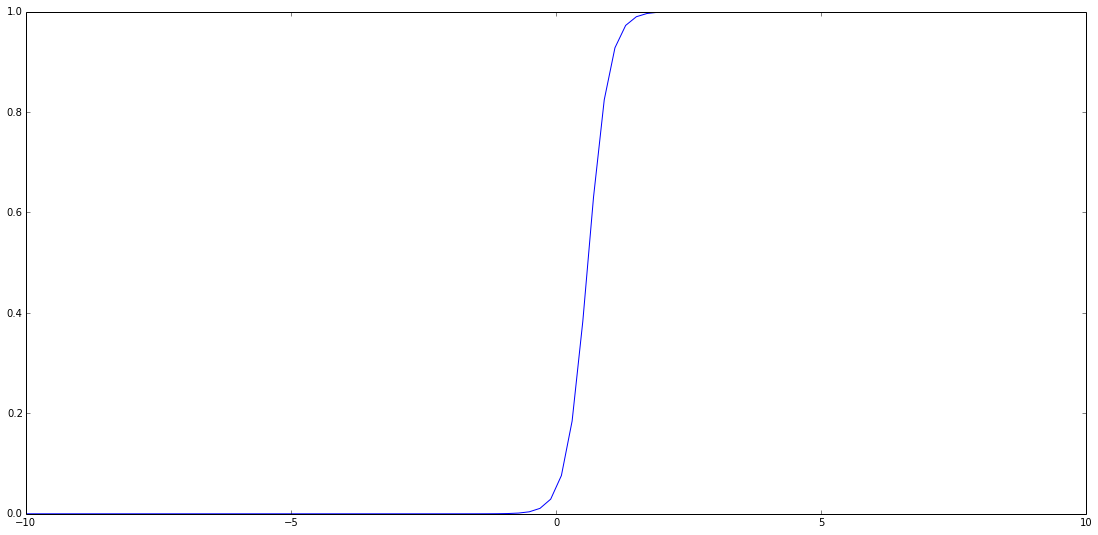

In [21]:
x = np.linspace(-10,10,100)

shift = 3
frac = 5

plt.figure(figsize=(19,9))
plt.plot(x, expit((x)*frac-shift))